# HRDPS analysis

HRDPS analysis notebook

***

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, dates, colors, patches
from cmocean import cm as cmo
from datetime import datetime, timedelta
from calendar import month_name
from scipy import interpolate
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

## Dominant circulation modes

In this section, we will determine the dominant flow patterns throughout the Salish Sea part of the HRDPS domain. The strategy will be to construct a new position field to describe the along-axis distance from the mouth of Juan de Fuca Strait, and then compare the wind angle over a 5-year hourly record to this along-axis position.

First, load the HRDPS record, define coordinate variables, and trim the inlets from the landmask. Also, define along-axis guides to be used to constuct the along-axis distance field.

In [3]:
# Load HRDPS record
HRDPS = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/HRDPS_1h_20141201_20200201_wind.nc')

# Define coordinate variables
longitude, latitude = [HRDPS[var].values for var in ('longitude', 'latitude')]
deg2m, coslat = 111e3, np.cos(np.deg2rad(50))

# Limit HRDPS mask to open water
mask_trimmed = np.copy(HRDPS.landmask.values)
mask_trimmed[20:40, 40:50] = 0 # Saanich Inlet
mask_trimmed[:, 72:] = 0       # Boundary Bay
mask_trimmed[40:, 61:] = 0     # Fraser River
mask_trimmed[58:, 53:] = 0     # Howe Sound
mask_trimmed[76:, 35:] = 0     # Jervis Inlet
mask_trimmed[100:, :] = 0      # Discovery Islands

# Define along-axis guides (x, y)
guides = {
    'west': [(2, 40), (40, 15), (45, 20), (45, 35), (18, 60), (0, 97)],
    'east': [(0, 15), (40, 0), (73, 0), (73, 45), (45, 75), (18, 106)],
}

Preview trimmed mask (red) and along-axis guides (blue).

In [4]:
def plot_map(ax):
    ax.contourf(HRDPS.landmask, levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(HRDPS.landmask, levels=[-0.01, 0.01], colors='k')
    ax.contour(mask_trimmed, levels=[-0.01, 0.01], colors='r')
    for cst in guides: ax.plot(*[[xy[dim] for xy in guides[cst]] for dim in (0, 1)], 'bo--')
    ax.set_ylim([0, 110])
    ax.set_aspect(1)

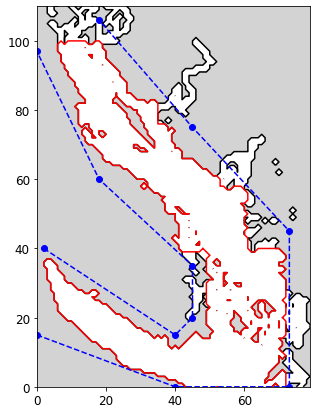

In [5]:
# Plot map
fig, ax = plt.subplots(figsize=(5, 7))
plot_map(ax)

Next, define along-axis distance along the midpoints of each cross-axis segment between the west/east guides based on the longitude and latitude coordinate variables.

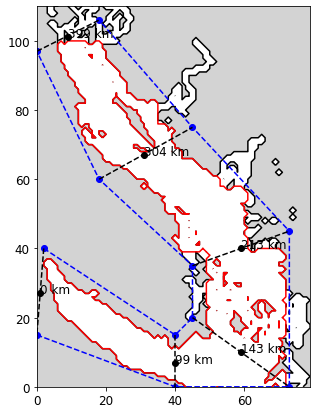

In [6]:
# Plot map
fig, ax = plt.subplots(figsize=(5, 7))
plot_map(ax)

# Find lon and lat at the midpoint of each cross-axis segment
lons, lats, midpoints = [], [], []
for segment in zip(*guides.values()):
    xy = [[xy[dim] for xy in segment] for dim in (0, 1)]
    midpoint = tuple(int((coord[1] - coord[0]) / 2 + coord[0]) for coord in xy)
    lon, lat = [coord[midpoint[::-1]] for coord in (longitude, latitude)]
    lons.append(lon), lats.append(lat), midpoints.append(midpoint)
    ax.plot(*xy, 'k--')
    ax.plot(*midpoint, 'ko')

# Define along-axis distance on the midpoints according to the lon and lat differences
distance = np.sqrt((np.diff(lons) * deg2m * coslat)**2 + (np.diff(lats) * deg2m)**2)
distance = list(np.insert(np.cumsum(distance), 0, 0))
for point, dist in zip(midpoints, distance): ax.text(*point, f'{1e-3*dist:.0f} km')

Now, assign the distances at the midpoints (black) to the guide points (blue), and interpolate onto the HRDPS grid.

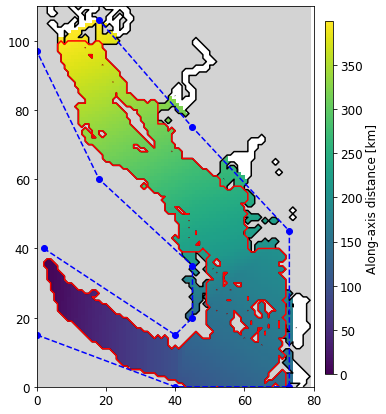

In [7]:
# Interpolate distances onto HRDPS grid
guidepoints = [[], []]
for dim in (0, 1):
    for cst in guides:
        guidepoints[dim].extend([xy[dim] for xy in guides[cst]])
xi = tuple(np.meshgrid(*[np.arange(len(HRDPS[dim])) for dim in ('gridX', 'gridY')]))
distance_interp = interpolate.griddata(tuple(guidepoints), distance + distance, xi)

# Plot map
fig, ax = plt.subplots(figsize=(5, 7))
plot_map(ax)
c = ax.pcolormesh(1e-3*distance_interp, zorder=0)
cax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cax, label='Along-axis distance [km]')

We now have a gridded field of along-axis distance, along with hourly wind velocity. The next step is to calculate wind direction over the water points and compare with distance.

In [8]:
# Process wind
mask_flat = mask_trimmed.reshape(-1).astype('bool')
u, v = [HRDPS[var].values for var in ['u_wind', 'v_wind']]
dist = np.broadcast_to(distance_interp, u.shape)
dist, u, v = [var.reshape(-1, len(mask_flat))[:, mask_flat].flatten() for var in (dist, u, v)]
wspd = np.sqrt(u**2 + v**2)
wdir = np.rad2deg(np.arctan2(v, u)) - 90   # CCW from N
wdir[wdir < 0] = wdir[wdir < 0] + 360      # shift to 0-360

Plot a 2-D histogram of distance versus wind direction.

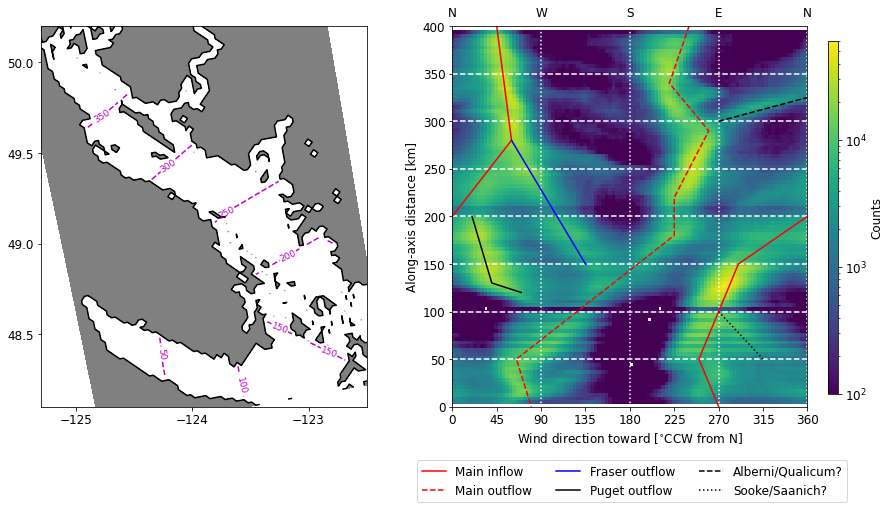

In [9]:
# Make plot area
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot map and distance contours
axs[0].contourf(longitude, latitude, HRDPS.landmask, levels=[-0.01, 0.01], colors='gray')
axs[0].contour(longitude, latitude, HRDPS.landmask, levels=[-0.01, 0.01], colors='k')
c = axs[0].contour(
    longitude, latitude, 1e-3*np.ma.masked_where(HRDPS.landmask==0, distance_interp),
    levels=np.arange(0, 400, 50), colors='m', linestyles='--',
)
axs[0].clabel(c, fmt='%.0f', fontsize=9, inline_spacing=0)

# Plot wind direction vs along-axis distance, for wind speed > 5 m/s
_, _, _, c = axs[1].hist2d(wdir[wspd>5], 1e-3*dist[wspd>5], bins=100, norm=colors.LogNorm(vmin=1e2, vmax=6e4))

# Add grid lines
for y in np.arange(0, 400, 50): axs[1].plot([0, 360], [y, y], 'w--')
for x, label in zip(np.arange(0, 361, 90), ['N', 'W', 'S', 'E', 'N']):
    axs[1].plot([x, x], [0, 400], 'w:')
    axs[1].text(x, 410, label, ha='center')

# Trace dominant flow patterns
axs[1].plot([45, 60, 0, np.nan, 360, 290, 250, 270], [400, 280, 200, np.nan, 200, 150, 50, 0], 'r-', label='Main inflow')
axs[1].plot([240, 220, 260, 225, 225, 65, 80], [400, 340, 290, 220, 180, 50, 0], 'r--', label='Main outflow')
axs[1].plot([60, 135], [280, 150], 'b-', label='Fraser outflow')
axs[1].plot([20, 40, 70], [200, 130, 120], 'k-', label='Puget outflow')
axs[1].plot([270, 360], [300, 325], 'k--', label='Alberni/Qualicum?')
axs[1].plot([270, 315], [100, 50], 'k:', label='Sooke/Saanich?')

# Formatting
lims = [(-125.3, -122.5, 48.1, 50.2), (0, 360, 0, 400)]
ticks = [(-125, -122, 1, 48.5, 50.1, 0.5), (0, 361, 45, 0, 401, 50)]
for ax, lim, tick in zip(axs, lims, ticks):
    ax.set_xlim(lim[:2])
    ax.set_ylim(lim[2:])
    ax.xaxis.set_ticks(np.arange(*tick[:3]))
    ax.yaxis.set_ticks(np.arange(*tick[3:]))
axs[0].set_aspect(1/coslat)
axs[1].set_xlabel('Wind direction toward [$^{\circ}$CCW from N]')
axs[1].set_ylabel('Along-axis distance [km]')
axs[1].legend(loc=(-0.1, -0.25), ncol=3)
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax, label='Counts')

***

## Wind speed climatology

In [11]:
time = HRDPS.time.values.astype('datetime64[s]').astype(datetime)
u, v = [HRDPS[var].values for var in ('u_wind', 'v_wind')]
wspd = np.sqrt(u**2 + v**2)

In [21]:
months = np.array([t.month for t in time])
wspd_mean = wspd.mean(axis=0)

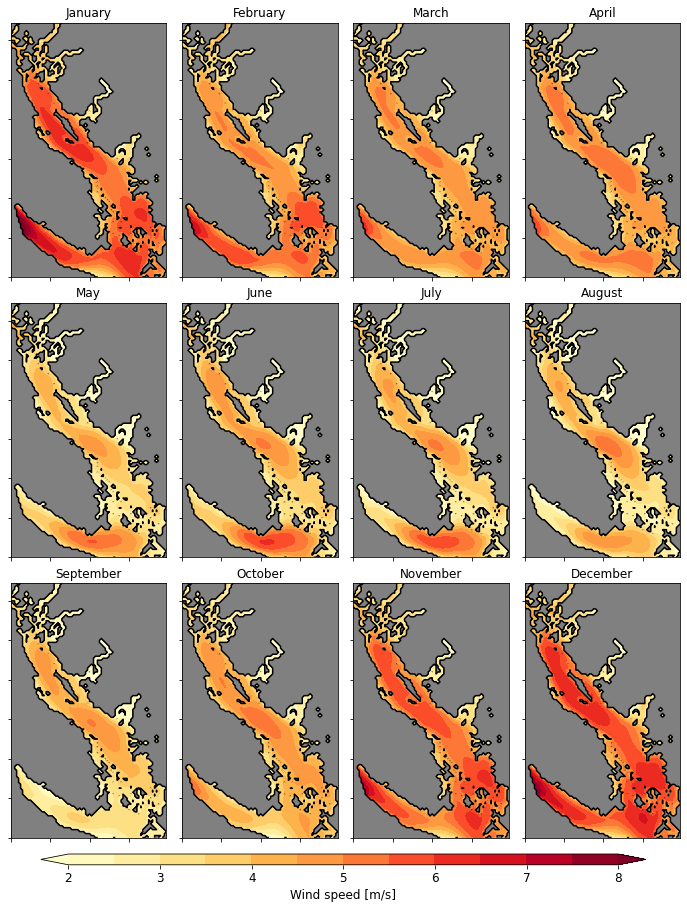

In [47]:
fig, axs = plt.subplots(3, 4, figsize=(12, 15), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for month, ax in zip(range(1, 13), axs.ravel()):
    c = ax.contourf(wspd[months == month, ...].mean(axis=0), levels=np.arange(2, 8.1, 0.5), cmap='YlOrRd', extend='both')
    ax.contourf(HRDPS.landmask, levels=[-0.01, 0.01], colors='gray', zorder=2)
    ax.contour(HRDPS.landmask, levels=[-0.01, 0.01], colors='k')
    ax.xaxis.set_ticklabels('')
    ax.yaxis.set_ticklabels('')
    ax.set_title(month_name[month])
    ax.set_aspect(1)
cax = fig.add_axes([0.16, 0.1, 0.7, 0.01])
fig.colorbar(c, cax, label='Wind speed [m/s]', orientation='horizontal')

***

## Interannual variability

In [14]:
# Limit HRDPS mask to open water
mask_trimmed = np.copy(HRDPS.landmask.values)
mask_trimmed[:25, :] = 0   # San Juan Islands
mask_trimmed[100:, :] = 0  # Discovery Islands
mask_trimmed[:40, :50] = 0 # Left corner
mask_trimmed[:40, 73:] = 0 # JdF/Gulf Islands
mask_trimmed[40:, 61:] = 0 # Fraser River
mask_trimmed[58:, 53:] = 0 # Howe Sound
mask_trimmed[76:, 35:] = 0 # Jervis Inlet

In [54]:
# Process wind
mask_flat = mask_trimmed.reshape(-1).astype('bool')
time = HRDPS.time.values.astype('datetime64[s]').astype(datetime)
u, v = [HRDPS[var].values for var in ('u_wind', 'v_wind')]
wspd = np.sqrt(u**2 + v**2)
wdir = np.rad2deg(np.arctan2(v, u)) - 90   # CCW from N
wdir[wdir < 0] = wdir[wdir < 0] + 360      # shift to 0-360

In [55]:
# Calculate monthly averages
seasons = {'Apr-Jun': [4, 7], 'Jul-Sep': [7, 10]}

wind = {}
for year in tqdm(range(2015, 2020)):
    wind[year] = {}
    for season in seasons:
        index = np.logical_and(time > datetime(year, seasons[season][0], 1), time < datetime(year, seasons[season][1], 1))
        wind[year][season] = wspd[index].mean(axis=0)

# Calculate mean
wind['mean'] = {}
for season in seasons:
    wind['mean'][season] = np.concatenate([wind[year][season][None, ...] for year in range(2015, 2020)], axis=0).mean(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

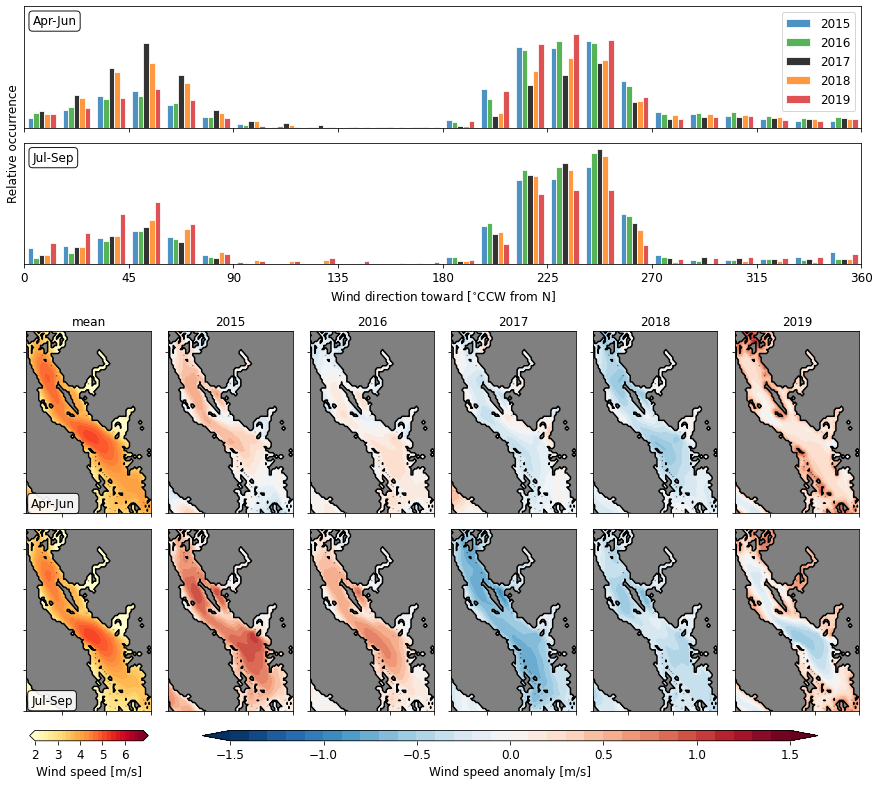

In [126]:
# Build figure layout
fig = plt.figure(figsize=(15, 12))
gs = plt.GridSpec(4, 6, wspace=0.1, hspace=0.1, height_ratios=[1, 1, 1.5, 1.5])

# Plotting properties
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]

# Plot Timeseries
for row, season in zip(range(2), seasons):
    ax = fig.add_subplot(gs[row, :])
    pos = ax.get_position()
    pos.y0, pos.y1 = pos.y0 + 0.06, pos.y1 + 0.06
    ax.set_position(pos.bounds)
    ax.set_xlim([0, 360])
    ax.set_ylim([0, 0.015])
    ax.xaxis.set_ticks(range(0, 361, 45))
    ax.yaxis.set_ticks([])
    ax.text(0.01, 0.85, season, transform=ax.transAxes, bbox=bbox)
    x = []
    for year, color in zip(range(2015, 2020), palette):
        index = np.logical_and(time > datetime(year, seasons[season][0], 1), time < datetime(year, seasons[season][1], 1))
        wspd_flat, wdir_flat = [var[index].reshape(-1, len(mask_flat))[:, mask_flat].ravel() for var in (wspd, wdir)]
        x.append(wdir_flat[wspd_flat > 5])
    _ = ax.hist(x, bins=range(0, 361, 15), density=True, color=palette, edgecolor='w', alpha=0.8, label=range(2015, 2020))
    if row == 0:
        ax.xaxis.set_ticklabels('')
        ax.legend(loc=1)
    else:
        ax.set_xlabel('Wind direction toward [$^{\circ}$CCW from N]')
        ax.set_ylabel('Relative occurrence', y=1)

for row, season in zip(range(2, 4), seasons):
    for col, key in zip(range(6), ['mean'] + list(range(2015, 2020))):
        ax = fig.add_subplot(gs[row, col])
        ax.contourf(HRDPS.landmask, levels=[-0.01, 0.01], colors='gray', zorder=2)
        ax.contour(HRDPS.landmask, levels=[-0.01, 0.01], colors='k')
        ax.set_xlim([5, 75])
        ax.set_ylim([20, 110])
        ax.xaxis.set_ticklabels('')
        ax.yaxis.set_ticklabels('')
        ax.set_aspect(5/4.4)
        if key == 'mean':
            c1 = ax.contourf(wind[key][season], levels=np.arange(2, 7, 0.2), cmap='YlOrRd', extend='both')
            ax.text(0.04, 0.035, season, transform=ax.transAxes, bbox=bbox)
        else: c2 = ax.contourf(wind[key][season] - wind['mean'][season], levels=np.arange(-1.5, 1.6, 0.1), cmap='RdBu_r', extend='both')
        if season == 'Apr-Jun': ax.set_title(key)

for c, xpos, ticks, label in zip([c1, c2], [(0.13, 0.11), (0.29, 0.57)], [(2, 8, 1), (-1.5, 1.6, 0.5)], ['Wind speed', 'Wind speed anomaly']):
    cax = fig.add_axes([xpos[0], 0.09, xpos[1], 0.012])
    fig.colorbar(c, cax=cax, orientation='horizontal', label=f'{label} [m/s]', ticks=np.arange(*ticks))

#fig.savefig('/home/bmoorema/Desktop/upwelling_processes_figs/wind_anomalies.pdf', bbox_inches='tight')